In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
from geopy.geocoders import Nominatim

In [31]:
df_mapa = gpd.read_file(r"Map_comunas\comunas_wgs84.shp")
df_mapa.head()

,ID,OBJETO,COMUNAS,BARRIOS,PERIMETRO,AREA,geometry
0,1,LIMITE COMUNAL,2.0,RECOLETA,21452.838648,6.317265e+06,"POLYGON ((-58.38000 -34.57002, -58.38002 -34.5..."
1,3,LIMITE COMUNAL,6.0,CABALLITO,10990.964471,6.851029e+06,"POLYGON ((-58.43061 -34.60705, -58.43056 -34.6..."
2,6,LIMITE COMUNAL,10.0,FLORESTA - MONTE CASTRO - VELEZ SARSFIELD - VE...,18332.037457,1.265656e+07,"POLYGON ((-58.48834 -34.62016, -58.48820 -34.6..."
3,7,LIMITE COMUNAL,11.0,VILLA DEL PARQUE - VILLA DEVOTO - VILLA GRAL....,19987.696155,1.412004e+07,"POLYGON ((-58.49838 -34.59637, -58.49718 -34.5..."
4,8,LIMITE COMUNAL,12.0,COGHLAN - SAAVEDRA - VILLA PUEYRREDON - VILLA ...,17232.189372,1.557093e+07,"POLYGON ((-58.50331 -34.59386, -58.50347 -34.5..."


In [32]:
# Se carga el dataframe
df_homicidios = pd.read_csv(r"Datasets\homicidios_clean.csv")

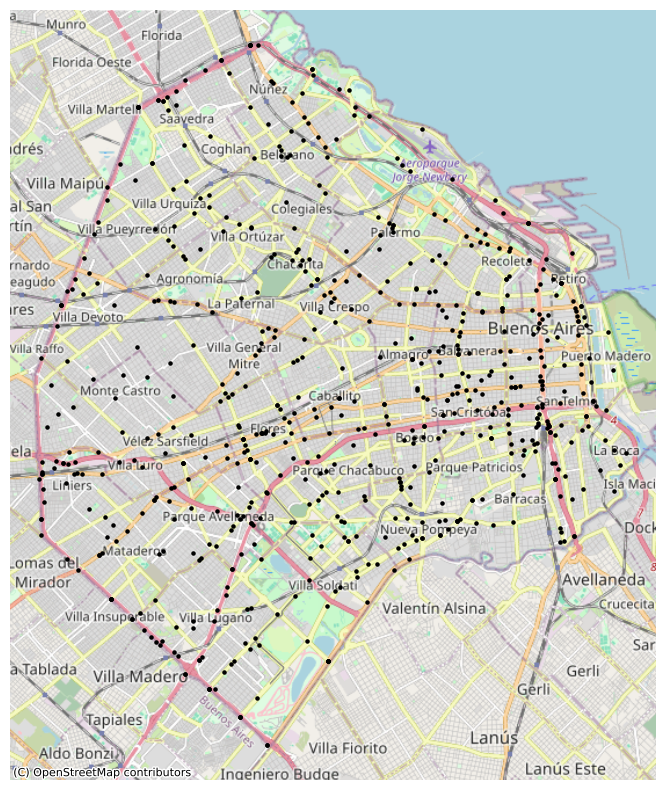

In [33]:
# Convert the DataFrame to a GeoDataFrame in WGS84 (latitud/longitud)
gdf_homicidios = gpd.GeoDataFrame(
    df_homicidios, 
    geometry=gpd.points_from_xy(df_homicidios['Pos x'], df_homicidios['Pos y'])
)
gdf_homicidios.crs = 'epsg:4326'  # Set coordinate reference system to WGS84

# Filter out rows with 'Pos x' or 'Pos y' equal to 0 or '.'
gdf_homicidios = gdf_homicidios[(gdf_homicidios['Pos x'] != 0) & (gdf_homicidios['Pos y'] != 0) & (gdf_homicidios['Pos x'] != '.') & (gdf_homicidios['Pos y'] != '.')]

# Convert to Web Mercator for contextily basemap
gdf_homicidios = gdf_homicidios.to_crs(epsg=3857)

# Plotting with the basemap
ax = gdf_homicidios.plot(marker='o', color='black', markersize=5, figsize=(10, 10))  # Adjust markersize as needed
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)  # Using OpenStreetMap.Mapnik as the basemap
ax.set_axis_off()
plt.show()

In [34]:
df_homicidios.describe()

,Nro víctimas,Año,Comuna,Pos x,Pos y,Hora,Edad
count,676.0,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000
mean,1.0,2018.201183,7.412722,-57.490327,-34.056211,11.752959,39.569527
std,0.0,1.694715,4.388174,7.399630,4.383461,6.694358,22.087896
min,1.0,2016.000000,1.000000,-58.529942,-34.705250,0.000000,0.000000
25%,1.0,2017.000000,4.000000,-58.475380,-34.643089,6.000000,25.000000
50%,1.0,2018.000000,8.000000,-58.443129,-34.622535,11.000000,35.000000
75%,1.0,2020.000000,11.000000,-58.399310,-34.594876,18.000000,55.250000
max,1.0,2021.000000,15.000000,0.000000,0.000000,23.000000,95.000000


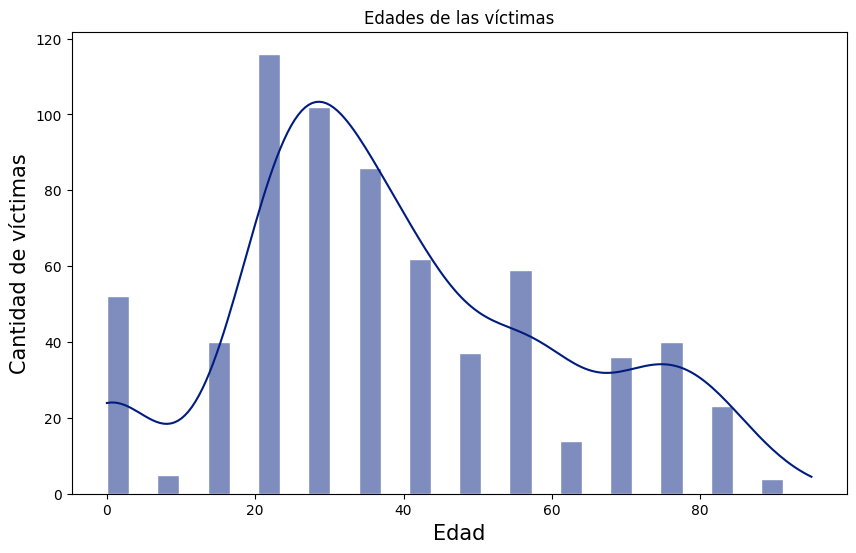

In [35]:
# Establecer la paleta de colores
sns.set_palette("dark")

# Histograma
plt.figure(figsize=(10, 6))
sns.histplot(data=df_homicidios, x='Edad', kde=True)
plt.title('Edades de las víctimas')
plt.xlabel('Edad', fontsize=15)  # Ajustar el tamaño de la fuente en el eje x
plt.ylabel('Cantidad de víctimas', fontsize=15)  # Ajustar el tamaño de la fuente en el eje y

# Ajustar el ancho de las columnas y los colores
bars = plt.gca().patches
for bar in bars:
    bar.set_width(3)  # Ajustar el ancho de las columnas
    bar.set_edgecolor('white')  # Ajustar el color del borde de las columnas

plt.show()

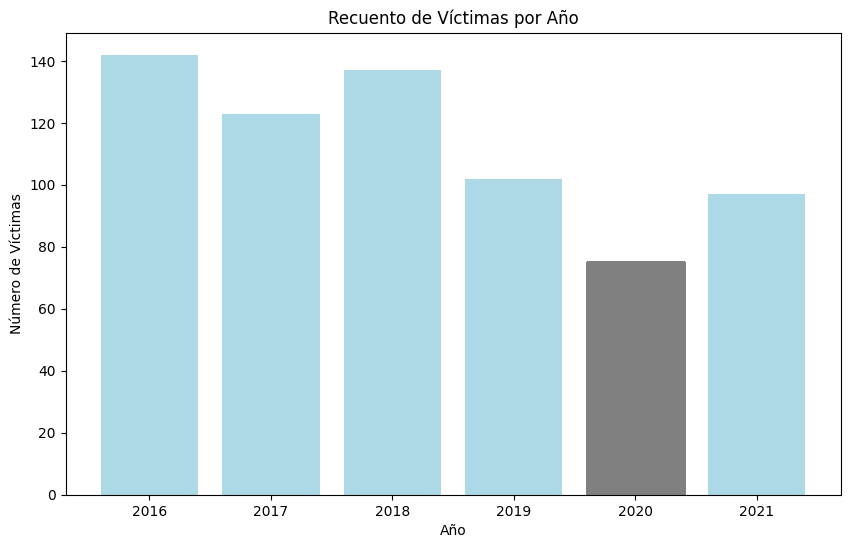

In [36]:
# Crear una nueva columna con el recuento de víctimas por año
df_homicidios['Recuento de Víctimas'] = df_homicidios.groupby('Año')['Nro víctimas'].transform('count')

# Obtener el año con el menor recuento de víctimas
año_menor_recuento = df_homicidios[df_homicidios['Recuento de Víctimas'] == df_homicidios['Recuento de Víctimas'].min()]['Año'].values[0]

# Crear el gráfico de barras con el recuento de víctimas por año
plt.figure(figsize=(10, 6))
bars = plt.bar(df_homicidios['Año'], df_homicidios['Recuento de Víctimas'], color='lightblue')

# Resaltar en color el año con el menor recuento de víctimas
for bar in bars:
    if bar.get_height() == df_homicidios['Recuento de Víctimas'].min():
        bar.set_color('grey')

# Personalizar el gráfico
plt.xlabel('Año')
plt.ylabel('Número de Víctimas')
plt.title('Recuento de Víctimas por Año')

# Mostrar el gráfico
plt.show()

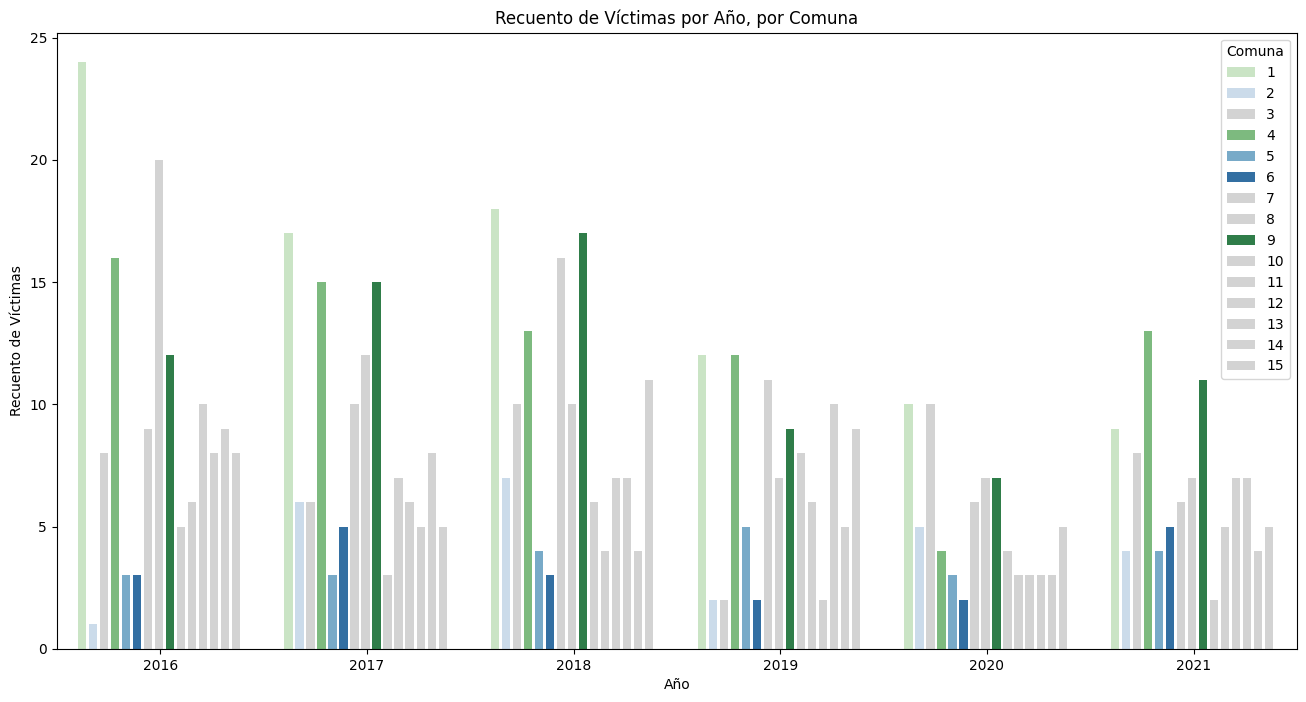

In [37]:
# Calcular las víctimas totales por comuna
df_homicidios['Total Víctimas'] = df_homicidios.groupby('Comuna')['Nro víctimas'].transform('sum')

# Identificar las comunas con mayor y menor cantidad de víctimas totales
comunas_con_mas_victimas = df_homicidios.groupby('Comuna')['Total Víctimas'].sum().nlargest(3)
comunas_con_menos_victimas = df_homicidios.groupby('Comuna')['Total Víctimas'].sum().nsmallest(3)

# Crear una escala de colores para las comunas con más y menos víctimas
colores_mas_victimas = sns.color_palette("Greens", 3)  # De más claro a más oscuro
colores_menos_victimas = sns.color_palette("Blues", 3)  # De más oscuro a más claro

# Asignar colores a las comunas
palette_dict = {}
for comuna in df_homicidios['Comuna'].unique():
    if comuna in comunas_con_mas_victimas.index:
        # Asignar el color según el orden de las víctimas
        idx = comunas_con_mas_victimas.index.get_loc(comuna)
        palette_dict[comuna] = colores_mas_victimas[idx]
    elif comuna in comunas_con_menos_victimas.index:
        # Asignar el color según el orden inverso de las víctimas
        idx = comunas_con_menos_victimas.index.get_loc(comuna)
        palette_dict[comuna] = colores_menos_victimas[::-1][idx]
    else:
        palette_dict[comuna] = 'lightgrey'

# Crear el gráfico
plt.figure(figsize=(16, 8))
ax = sns.countplot(data=df_homicidios, x='Año', hue='Comuna', palette=palette_dict)

# Personalizar el gráfico
plt.xlabel('Año')
plt.ylabel('Recuento de Víctimas')
plt.title('Recuento de Víctimas por Año, por Comuna')

# Ajustar el ancho de las columnas
for patch in ax.patches:
    patch.set_width(0.04)

# Mostrar el gráfico
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_1816\286358802.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_homicidios, x='Víctima', palette='pastel')


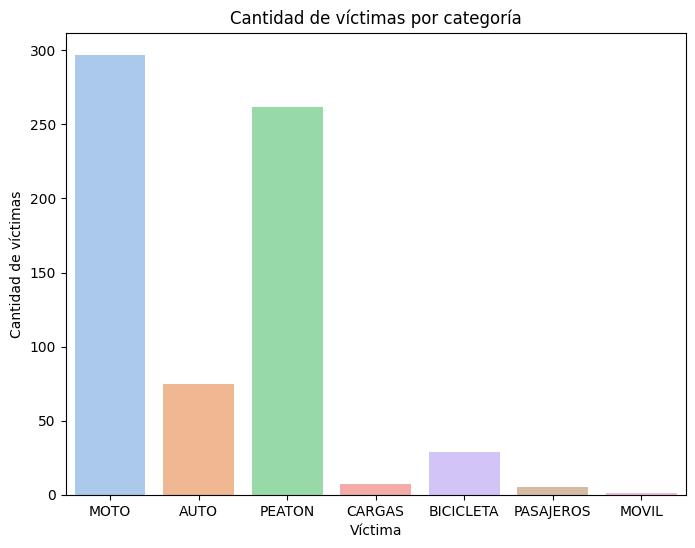

In [38]:
# gráfico de víctimas por categoria
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(data=df_homicidios, x='Víctima', palette='pastel')
ax.set_title('Cantidad de víctimas por categoría')
ax.set_ylabel('Cantidad de víctimas')
plt.show()

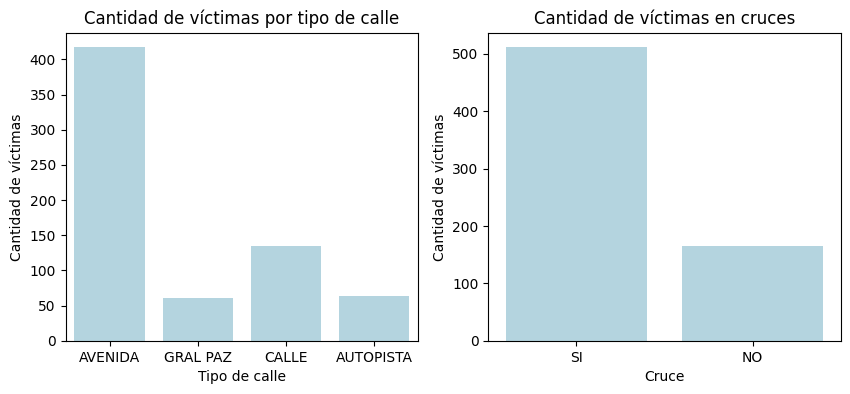

In [39]:
# Se crea el gráfico
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Gráfico de cantidad de víctimas por tipo de calle
sns.countplot(data=df_homicidios, x='Tipo de calle', ax=axes[0], color='lightblue')
axes[0].set_title('Cantidad de víctimas por tipo de calle')
axes[0].set_ylabel('Cantidad de víctimas')

# Gráfico de cantidad de víctimas en cruces
sns.countplot(data=df_homicidios, x='Cruce', ax=axes[1], color='lightblue')
axes[1].set_title('Cantidad de víctimas en cruces')
axes[1].set_ylabel('Cantidad de víctimas')

# Mostramos los gráficos
plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_1816\3218688193.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_homicidios, x='Rol', palette='pastel')


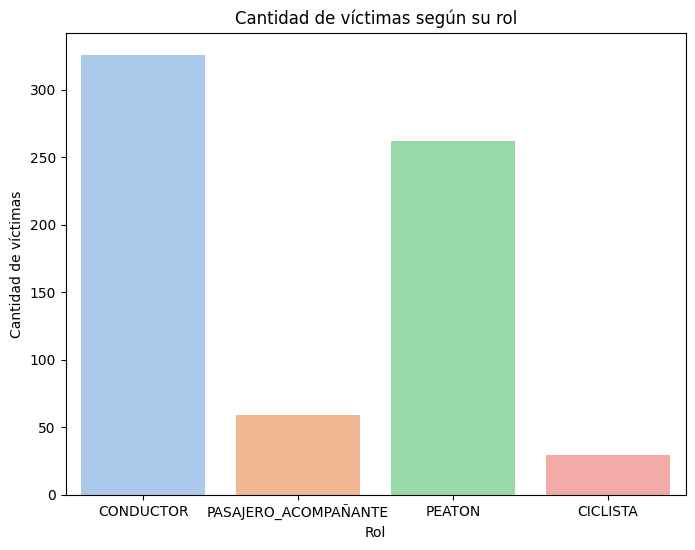

In [41]:
# Gráfico de cantidad de víctimas por rol
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(data=df_homicidios, x='Rol', palette='pastel')
ax.set_title('Cantidad de víctimas según su rol')
ax.set_ylabel('Cantidad de víctimas')
plt.show()

In [42]:
# Convertir la columna "COMUNAS" de float a entero
df_mapa['COMUNAS'] = df_mapa['COMUNAS'].astype(int)

In [43]:
# Se realiza un merge para combinar al dataframe homicidios solo las columnas nuevas del dataset mapa
df_homicidios = df_homicidios.merge(
    df_mapa[['COMUNAS', 'BARRIOS', 'AREA']],
    left_on='Comuna', right_on='COMUNAS', how='left')

# Se elimina la columna duplicada 'COMUNAS' a partir de la cual se realizó el merge con 'Comuna'
df_homicidios.drop(columns=['COMUNAS','Recuento de Víctimas', 'Total Víctimas'], inplace=True)
df_homicidios.head()

,Id,Nro víctimas,Año,Mes,Día,Hora estandar,Tipo de calle,Cruce,Lugar del hecho,Comuna,...,Participantes,Víctima,Acusado,Hora,Rol,Sexo,Edad,FECHA_FALLECIMIENTO,BARRIOS,AREA
0,2016-0001,1,2016,Enero,Viernes,4,AVENIDA,SI,"PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,...,MOTO-AUTO,MOTO,AUTO,4,CONDUCTOR,MASCULINO,19,1/1/2016,VILLA LUGANO - VILLA RIACHUELO - VILLA SOLDATI,2.221690e+07
1,2016-0002,1,2016,Enero,Sábado,1,GRAL PAZ,SI,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,...,AUTO-PASAJEROS,AUTO,PASAJEROS,1,CONDUCTOR,MASCULINO,70,1/2/2016,LINIERS - MATADEROS - PARQUE AVELLANEDA,1.650531e+07
2,2016-0003,1,2016,Enero,Domingo,7,AVENIDA,NO,ENTRE RIOS AV. 2034,1,...,MOTO-AUTO,MOTO,AUTO,7,CONDUCTOR,MASCULINO,30,1/3/2016,CONSTITUCION - MONTSERRAT - PUERTO MADERO - RE...,1.779457e+07
3,2016-0004,1,2016,Enero,Domingo,0,AVENIDA,SI,"LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8,...,MOTO-SD,MOTO,SD,0,CONDUCTOR,MASCULINO,18,SD,VILLA LUGANO - VILLA RIACHUELO - VILLA SOLDATI,2.221690e+07
4,2016-0005,1,2016,Enero,Jueves,5,AVENIDA,SI,"SAN JUAN AV. y SAENZ PEÑA, LUIS, PRES.",1,...,MOTO-PASAJEROS,MOTO,PASAJEROS,5,CONDUCTOR,MASCULINO,29,2/1/2016,CONSTITUCION - MONTSERRAT - PUERTO MADERO - RE...,1.779457e+07


In [44]:
df_homicidios.to_csv(r"Datasets\homicidios_clean_eda.csv", index=False)